In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

# Set up matplotlib for better visualization
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline


In [2]:
def calculate_metrics(img):
    """Calculate image quality metrics"""
    metrics = {
        'mean': np.mean(img),
        'std': np.std(img),
        'min': np.min(img),
        'max': np.max(img),
        'dynamic_range': np.max(img) - np.min(img),
        'contrast': np.std(img) / np.mean(img) if np.mean(img) > 0 else 0
    }
    return metrics

def plot_histogram_comparison(original_path, clahe_path, folder_name):
    """Create comprehensive histogram comparison for a folder"""
    
    # Read images
    original = cv2.imread(original_path, cv2.IMREAD_GRAYSCALE)
    clahe = cv2.imread(clahe_path, cv2.IMREAD_GRAYSCALE)
    
    if original is None or clahe is None:
        print(f"Error reading images from {folder_name}")
        return
    
    # Calculate metrics
    original_metrics = calculate_metrics(original)
    clahe_metrics = calculate_metrics(clahe)
    
    # Create figure with subplots
    fig = plt.figure(figsize=(16, 10))
    
    # Main title
    fig.suptitle(f'Low Light Enhancement Evaluation - {folder_name}', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # 1. Original Image
    ax1 = plt.subplot(3, 3, 1)
    ax1.imshow(original, cmap='gray')
    ax1.set_title('Original Image', fontsize=12, fontweight='bold')
    ax1.axis('off')
    
    # 2. CLAHE Image
    ax2 = plt.subplot(3, 3, 2)
    ax2.imshow(clahe, cmap='gray')
    ax2.set_title('CLAHE Enhanced Image', fontsize=12, fontweight='bold')
    ax2.axis('off')
    
    # 3. Difference Map
    ax3 = plt.subplot(3, 3, 3)
    diff = cv2.absdiff(clahe, original)
    ax3.imshow(diff, cmap='hot')
    ax3.set_title('Absolute Difference', fontsize=12, fontweight='bold')
    ax3.axis('off')
    
    # 4. Original Histogram
    ax4 = plt.subplot(3, 3, 4)
    hist_original = cv2.calcHist([original], [0], None, [256], [0, 256])
    ax4.plot(hist_original, color='blue', linewidth=2)
    ax4.fill_between(range(256), hist_original.flatten(), alpha=0.3, color='blue')
    ax4.set_title('Original Histogram', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Pixel Intensity')
    ax4.set_ylabel('Frequency')
    ax4.grid(True, alpha=0.3)
    
    # 5. CLAHE Histogram
    ax5 = plt.subplot(3, 3, 5)
    hist_clahe = cv2.calcHist([clahe], [0], None, [256], [0, 256])
    ax5.plot(hist_clahe, color='green', linewidth=2)
    ax5.fill_between(range(256), hist_clahe.flatten(), alpha=0.3, color='green')
    ax5.set_title('CLAHE Histogram', fontsize=12, fontweight='bold')
    ax5.set_xlabel('Pixel Intensity')
    ax5.set_ylabel('Frequency')
    ax5.grid(True, alpha=0.3)
    
    # 6. Overlay Histogram
    ax6 = plt.subplot(3, 3, 6)
    ax6.plot(hist_original, color='blue', linewidth=2, alpha=0.7, label='Original')
    ax6.plot(hist_clahe, color='green', linewidth=2, alpha=0.7, label='CLAHE')
    ax6.set_title('Histogram Overlay', fontsize=12, fontweight='bold')
    ax6.set_xlabel('Pixel Intensity')
    ax6.set_ylabel('Frequency')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    # 7. Cumulative Distribution Function (CDF)
    ax7 = plt.subplot(3, 3, 7)
    cdf_original = hist_original.cumsum()
    cdf_clahe = hist_clahe.cumsum()
    cdf_original_normalized = cdf_original / cdf_original.max()
    cdf_clahe_normalized = cdf_clahe / cdf_clahe.max()
    ax7.plot(cdf_original_normalized, color='blue', linewidth=2, label='Original')
    ax7.plot(cdf_clahe_normalized, color='green', linewidth=2, label='CLAHE')
    ax7.set_title('Cumulative Distribution Function', fontsize=12, fontweight='bold')
    ax7.set_xlabel('Pixel Intensity')
    ax7.set_ylabel('Cumulative Probability')
    ax7.legend()
    ax7.grid(True, alpha=0.3)
    
    # 8. Metrics Comparison
    ax8 = plt.subplot(3, 3, 8)
    ax8.axis('off')
    metrics_text = f"""
    Original Image Metrics:
    • Mean: {original_metrics['mean']:.2f}
    • Std Dev: {original_metrics['std']:.2f}
    • Min: {original_metrics['min']:.0f}
    • Max: {original_metrics['max']:.0f}
    • Dynamic Range: {original_metrics['dynamic_range']:.0f}
    • Contrast Ratio: {original_metrics['contrast']:.3f}
    
    CLAHE Enhanced Metrics:
    • Mean: {clahe_metrics['mean']:.2f}
    • Std Dev: {clahe_metrics['std']:.2f}
    • Min: {clahe_metrics['min']:.0f}
    • Max: {clahe_metrics['max']:.0f}
    • Dynamic Range: {clahe_metrics['dynamic_range']:.0f}
    • Contrast Ratio: {clahe_metrics['contrast']:.3f}
    """
    ax8.text(0.1, 0.5, metrics_text, fontsize=10, verticalalignment='center',
             family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # 9. Improvement Summary
    ax9 = plt.subplot(3, 3, 9)
    ax9.axis('off')
    improvement_text = f"""
    Improvement Analysis:
    
    • Mean Brightness: {((clahe_metrics['mean'] - original_metrics['mean']) / original_metrics['mean'] * 100):+.1f}%
    
    • Std Dev: {((clahe_metrics['std'] - original_metrics['std']) / original_metrics['std'] * 100):+.1f}%
    
    • Dynamic Range: {((clahe_metrics['dynamic_range'] - original_metrics['dynamic_range']) / original_metrics['dynamic_range'] * 100):+.1f}%
    
    • Contrast: {((clahe_metrics['contrast'] - original_metrics['contrast']) / original_metrics['contrast'] * 100):+.1f}%
    
    Overall: {'✓ Improved' if clahe_metrics['contrast'] > original_metrics['contrast'] else '✗ Degraded'}
    """
    ax9.text(0.1, 0.5, improvement_text, fontsize=11, verticalalignment='center',
             family='monospace', fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.6))
    
    plt.tight_layout()
    plt.show()
    
    return original_metrics, clahe_metrics


Found 2 folders to process:
  - PB231640
  - PB231683

Processing folder: PB231640
Original: PB231640_original_gray.png
CLAHE:    PB231640_clahe.png


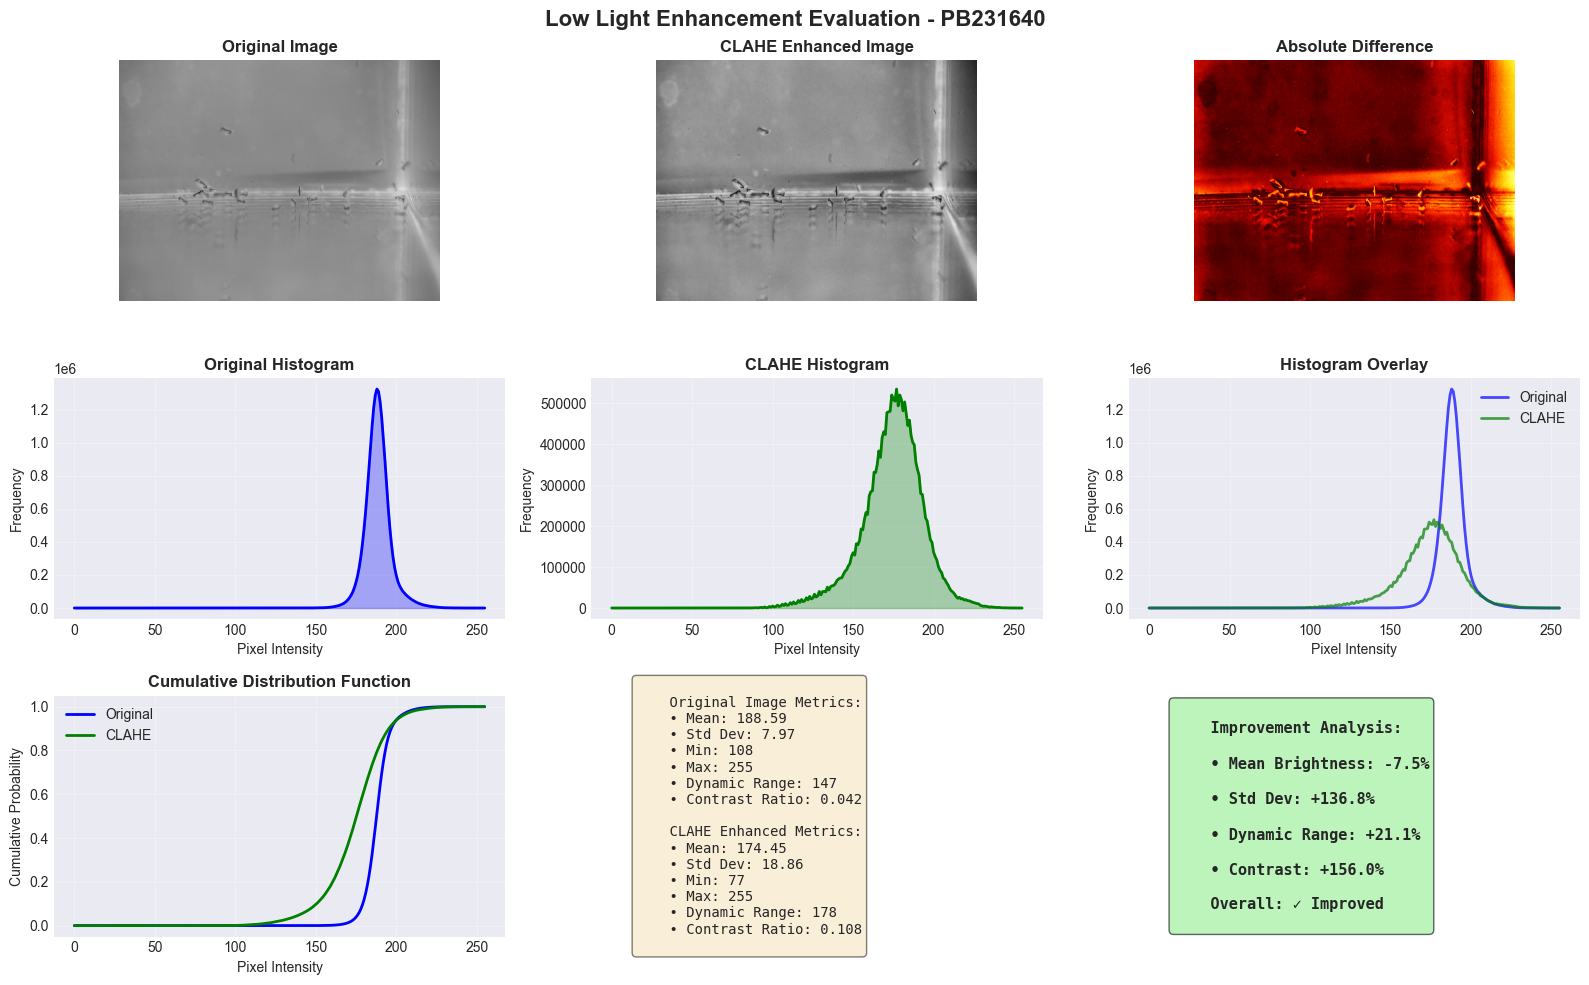


Processing folder: PB231683
Original: PB231683_original_gray.png
CLAHE:    PB231683_clahe.png


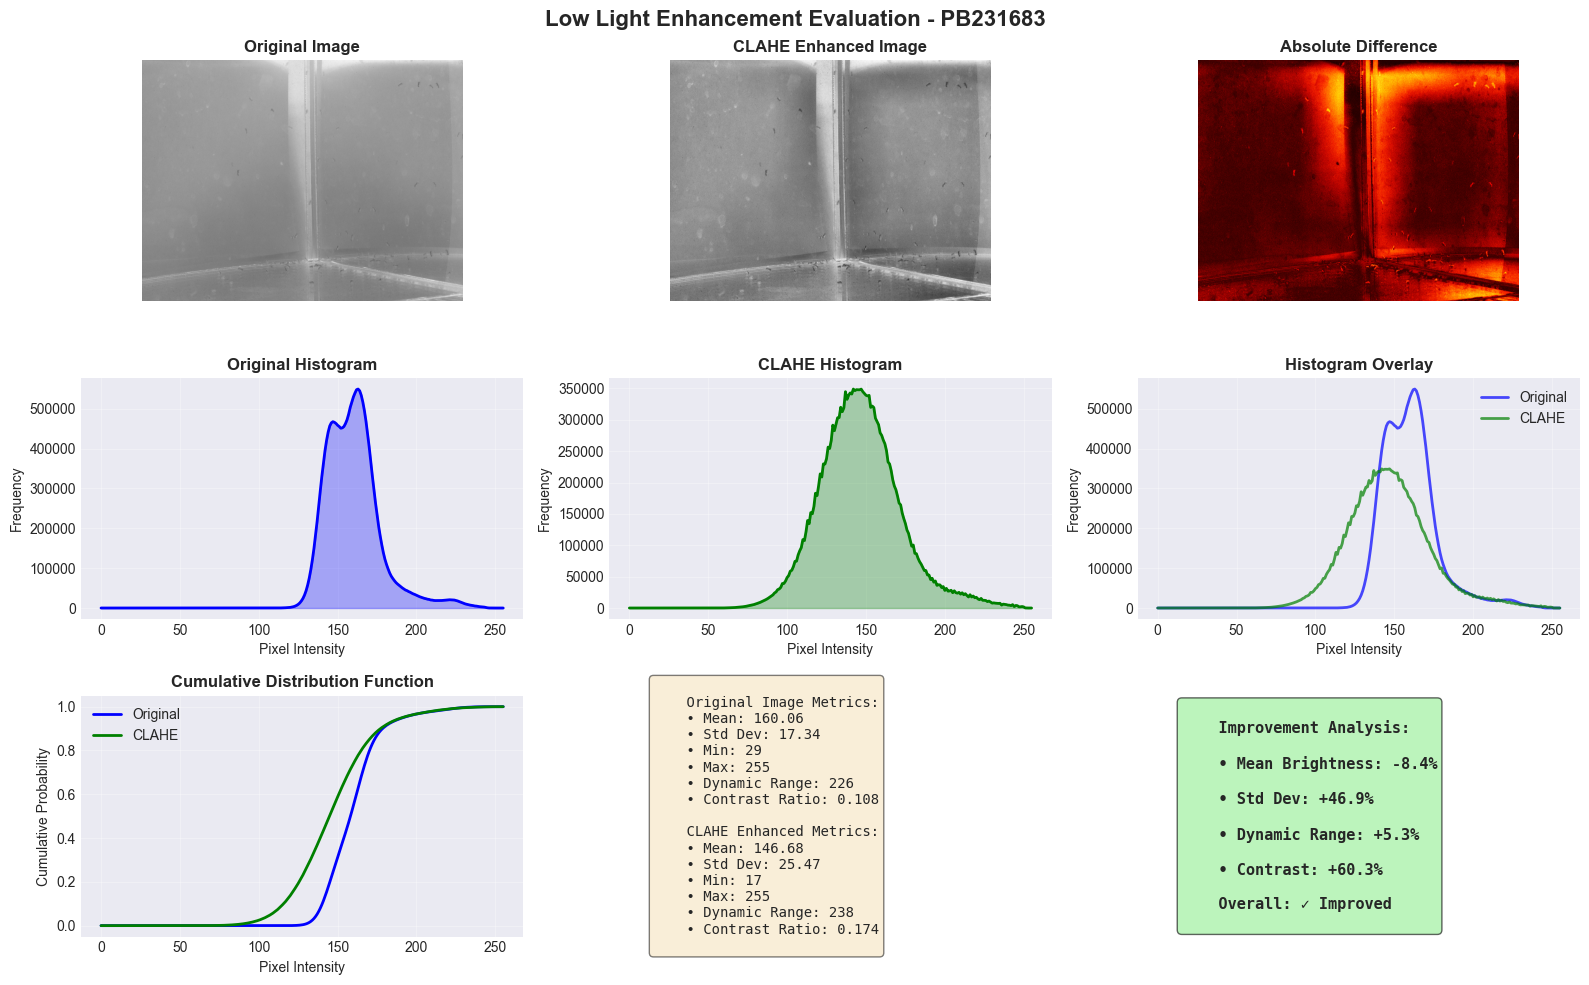


Processing Complete!


In [3]:
# Main processing
lowlight_dir = Path('lowlight')

# Find all subfolders in lowlight directory
folders = [f for f in lowlight_dir.iterdir() if f.is_dir()]

print(f"Found {len(folders)} folders to process:")
for folder in folders:
    print(f"  - {folder.name}")

# Process each folder
all_results = {}

for folder in folders:
    print(f"\n{'='*60}")
    print(f"Processing folder: {folder.name}")
    print('='*60)
    
    # Find the original and clahe images
    original_img = None
    clahe_img = None
    
    for file in folder.iterdir():
        if file.suffix.lower() == '.png':
            if 'original_gray' in file.name or 'original' in file.name:
                original_img = file
            elif 'clahe' in file.name and 'comparison' not in file.name:
                clahe_img = file
    
    if original_img and clahe_img:
        print(f"Original: {original_img.name}")
        print(f"CLAHE:    {clahe_img.name}")
        
        # Create histogram comparison
        original_metrics, clahe_metrics = plot_histogram_comparison(
            str(original_img), 
            str(clahe_img), 
            folder.name
        )
        
        all_results[folder.name] = {
            'original': original_metrics,
            'clahe': clahe_metrics
        }
    else:
        print(f"Warning: Could not find both original and CLAHE images in {folder.name}")
        if original_img:
            print(f"  Found original: {original_img.name}")
        if clahe_img:
            print(f"  Found CLAHE: {clahe_img.name}")

print(f"\n{'='*60}")
print("Processing Complete!")
print('='*60)


In [4]:
# Summary comparison table
import pandas as pd

if all_results:
    summary_data = []
    
    for folder_name, metrics in all_results.items():
        orig = metrics['original']
        clahe = metrics['clahe']
        
        summary_data.append({
            'Folder': folder_name,
            'Original Mean': f"{orig['mean']:.2f}",
            'CLAHE Mean': f"{clahe['mean']:.2f}",
            'Mean Δ%': f"{((clahe['mean'] - orig['mean']) / orig['mean'] * 100):+.1f}%",
            'Original Contrast': f"{orig['contrast']:.3f}",
            'CLAHE Contrast': f"{clahe['contrast']:.3f}",
            'Contrast Δ%': f"{((clahe['contrast'] - orig['contrast']) / orig['contrast'] * 100):+.1f}%",
            'Original Range': f"{orig['dynamic_range']:.0f}",
            'CLAHE Range': f"{clahe['dynamic_range']:.0f}",
            'Range Δ%': f"{((clahe['dynamic_range'] - orig['dynamic_range']) / orig['dynamic_range'] * 100):+.1f}%"
        })
    
    df = pd.DataFrame(summary_data)
    
    print("\n" + "="*100)
    print("SUMMARY: Low Light Enhancement Comparison")
    print("="*100)
    print(df.to_string(index=False))
    print("="*100)
else:
    print("No results to summarize.")



SUMMARY: Low Light Enhancement Comparison
  Folder Original Mean CLAHE Mean Mean Δ% Original Contrast CLAHE Contrast Contrast Δ% Original Range CLAHE Range Range Δ%
PB231640        188.59     174.45   -7.5%             0.042          0.108     +156.0%            147         178   +21.1%
PB231683        160.06     146.68   -8.4%             0.108          0.174      +60.3%            226         238    +5.3%
